# Hate speech Detection using CNN





In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from keras.layers import Embedding, Dense, Dropout, Input, LSTM, Bidirectional,GRU
from keras.layers import MaxPooling1D, Conv1D, Flatten
from keras.preprocessing import sequence, text
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import Callback

from gensim.models.keyedvectors import KeyedVectors
from sklearn import preprocessing
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from keras import optimizers

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.utils import class_weight

from sklearn import preprocessing
from sklearn.metrics import (
    classification_report as creport
)

# Data and AraVec2.0 (pre-trained word embeddings model) Loading

In [5]:
#pre-trained word embedding: https://github.com/bakrianoo/aravec/tree/master/AraVec%202.0
"""
Citation:
Abu Bakr Soliman, Kareem Eisa, and Samhaa R. El-Beltagy, “AraVec:
A set of Arabic Word Embedding Models for use in Arabic NLP”,
in proceedings of the 3rd International Conference on 
Arabic Computational Linguistics (ACLing 2017), Dubai, UAE, 2017.
"""
! unzip '/content/drive/MyDrive/tweets_sg_300.zip'  

Archive:  /content/drive/MyDrive/tweets_sg_300.zip
  inflating: tweets_sg_300           
  inflating: tweets_sg_300.trainables.syn1neg.npy  
  inflating: tweets_sg_300.wv.vectors.npy  


In [2]:
# Word_embedding_path
embedding_path = '/content/tweets_sg_300'           #Twitter-Skipgram model-300d(trained on 77,600,000 Arabic tweets)

In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')
train_data

,Tweet,Class
0,وزير الخارجية اللبناني جبران باسيل قال في سلسل...,normal
1,سورية بلد الحضارات تربطها بعلية او بحيوان,normal
2,اخي الحاج اذا شعرت انك محرجا من الانتقادات لتص...,normal
3,ما فيك تعيش بلا ما تكب فتن ليل نهار وبكرة قلهم...,normal
4,هذا البطل الذي قاتل وجاذف بحياته لتحيا انت يا ...,abusive
...,...,...
4671,كول هوا مرة تانيي وحلوا عن طيزو وطيزنا ومقلعين...,abusive
4672,رئيس روحي؟ تروح روحك انت وكل مين شدّ عمشدّك مش...,abusive
4673,إذا أرادت إسرائيل أن تضمن أمنها وهو حق عليها ا...,normal
4674,خليك بحالك يا نعيمي على أساس أنت مش مرتزق و طب...,abusive


In [4]:
print("Train data shape: {}". format(train_data.shape))

Train data shape: (4676, 2)


In [5]:
def get_embedding_matrix(word_index, embedding_index, vocab_dim):
    print('Building embedding matrix...')
    embedding_matrix = np.zeros((len(word_index) + 1, vocab_dim))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index.get_vector(word)
        except:
            pass
    print('Embedding matrix built.') 
    #print("Word index", word_index.items())
    #print(embedding_matrix) 
    return embedding_matrix


def get_init_parameters(path, ext=None):
    if ext == 'vec':
        word_model = KeyedVectors.load_word2vec_format(path).wv
    else:
        word_model = KeyedVectors.load(path).wv
    n_words = len(word_model.vocab)
    vocab_dim = word_model[word_model.index2word[0]].shape[0]
    index_dict = dict()
    for i in range(n_words):
        index_dict[word_model.index2word[i]] = i+1
    print('Number of words in the word embedding',n_words)
    #print('word_model', word_model)
    #print("index_dict",index_dict)
    return word_model, index_dict, n_words, vocab_dim

def get_max_length(text_data, return_line=False):
    max_length = 0
    long_line = ""
    for line in text_data:
        new = len(line.split())
        if new > max_length:
            max_length = new
            long_line = line
    if return_line:
        return long_line, max_length
    else:
        return max_length
    print("max",long_line,max_length)

def load_datasets(data_paths, header=True):
    x = []
    y = []
    for data_path in data_paths:
        with open(data_path, 'r') as f:
            for line in f:
                if header:
                    header = False
                else:
                    temp = line.split(',')
                    x.append(temp[0])
                    y.append(temp[1].replace('\n', ''))
    max_length = get_max_length(x)
    print('Max length:', max_length)
    return x,y, max_length

def get_train_test(train_raw_text, test_raw_text, n_words, max_length):
    tokenizer = text.Tokenizer(num_words=n_words)
    tokenizer.fit_on_texts(list(train_raw_text))
    word_index = tokenizer.word_index
   
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)

    return sequence.pad_sequences(train_tokenized, maxlen=max_length, padding='post', truncating='post'),\
           sequence.pad_sequences(test_tokenized, maxlen=max_length, padding='post', truncating='post'),\
           word_index

def class_str_2_ind(x_train, x_test, y_train, y_test, classes, n_words, max_length):
    print('Converting data to trainable form...')
    y_encoder = preprocessing.LabelEncoder()
    y_encoder.fit(classes)
    y_train = y_encoder.transform(y_train)
    y_test = y_encoder.transform(y_test)
    #print(y_train)
    #print(y_test)
    train_y_cat = np_utils.to_categorical(y_train, len(classes))
    x_vec_train, x_vec_test, word_index = get_train_test(x_train, x_test, n_words, max_length)
    print('Number of training examples: ' + str(len(x_vec_train)))
    print('Number of dev examples: ' + str(len(x_vec_test)))
    return x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index

In [6]:
WORD_MODEL, _, MAX_FEATURES, EMBED_SIZE = get_init_parameters(embedding_path) 

Number of words in the word embedding 331679


In [7]:
# load train data
train_data_path=["/content/drive/MyDrive/OSACT4"]
X, y, MAX_TEXT_LENGTH = load_datasets(train_data_path)
CLASSES_LIST = np.unique(y)
print('Label categories: ' + str(CLASSES_LIST))

Max length: 52
Label categories: ['abusive' 'hate' 'normal']


In [8]:
MAX_TEXT_LENGTH=52

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train, X_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(X_train, X_test, y_train, y_test, CLASSES_LIST, MAX_FEATURES, MAX_TEXT_LENGTH)
test_cat_y = np_utils.to_categorical(y_test, len(CLASSES_LIST))

Converting data to trainable form...
Number of training examples: 3740
Number of dev examples: 936


In [11]:
print("Tokens number: "+str(len(word_index)))

Tokens number: 14157


In [12]:
# Sequence length
print("Original sequence length: "+str(MAX_TEXT_LENGTH))

Original sequence length: 52


#  CNN model building:

In [13]:
def get_model(embedding_weights, word_index, vocab_dim, max_length, print_summary=True):
    """
    Create Neural Network With an Embedding layer
    """
    inp = Input(shape=(max_length,))
    model = Embedding(input_dim=len(word_index)+1,
                      output_dim=vocab_dim,
                      trainable=False,
                      weights=[embedding_weights])(inp)

    model = Conv1D(filters=25, kernel_size=5, padding='same', activation='relu')(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
   
    model = Dense(3, activation='sigmoid')(model)
    model = Model(inputs=inp, outputs=model)
    
    from keras import optimizers

    opt = optimizers.Adam(lr=0.0001)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model


def get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH):
    tmp = get_embedding_matrix(word_index, WORD_MODEL, EMBED_SIZE)
    model = get_model(tmp, word_index, EMBED_SIZE, MAX_TEXT_LENGTH, print_summary=True)
    return model


class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

def train_fit_predict(model, x_train, x_test, y_train, y_test, batch_size, epochs, TestCallback=TestCallback):
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs, verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=[TestCallback((x_test, y_test))])
    return history, model

In [14]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH)

Building embedding matrix...
Embedding matrix built.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 52)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 52, 300)           4247400   
_________________________________________________________________
conv1d (Conv1D)              (None, 52, 25)            37525     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 26, 25)            0         
_________________________________________________________________
flatten (Flatten)            (None, 650)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1953      
Total params: 4,286,878
Trainable params: 39,478
Non-trainable params: 4,2

In [15]:
time_start = time()
history, model = train_fit_predict(model,
                               X_train[:, :MAX_TEXT_LENGTH],
                               X_test[:, :MAX_TEXT_LENGTH],
                               train_y_cat, test_cat_y,
                               batch_size=500, epochs=20)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Epoch 1/20
8/8 [==============================] - 33s 124ms/step - loss: 1.0674 - accuracy: 0.4832 - val_loss: 1.0334 - val_accuracy: 0.6058

Testing loss: 1.0333709716796875, acc: 0.6057692170143127

Epoch 2/20
8/8 [==============================] - 0s 20ms/step - loss: 1.0203 - accuracy: 0.5952 - val_loss: 0.9932 - val_accuracy: 0.6346

Testing loss: 0.993209719657898, acc: 0.6346153616905212

Epoch 3/20
8/8 [==============================] - 0s 21ms/step - loss: 0.9820 - accuracy: 0.6135 - val_loss: 0.9581 - val_accuracy: 0.6400

Testing loss: 0.958083987236023, acc: 0.6399572491645813

Epoch 4/20
8/8 [==============================] - 0s 21ms/step - loss: 0.9492 - accuracy: 0.6160 - val_loss: 0.9283 - val_accuracy: 0.6400

Testing loss: 0.9283477663993835, acc: 0.6399572491645813

Epoch 5/20
8/8 [==============================] - 0s 20ms/step - loss: 0.9184 - accuracy: 0.6212 - val_loss: 0.9045 - val_accuracy: 0.6410

Testing loss: 0.904547929763794, acc: 0.6410256624221802

Epoch 

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [17]:
model.evaluate(X_test[:, :MAX_TEXT_LENGTH], test_cat_y, batch_size=1000)

1/1 [==============================] - 0s 108ms/step - loss: 0.7840 - accuracy: 0.6806


[0.7840132713317871, 0.6805555820465088]

In [18]:
y_pred = np.argmax(model.predict(X_test[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(test_cat_y, axis=1), y_pred, target_names=["normal", "abusive", "hate"],digits=3))

              precision    recall  f1-score   support

      normal      0.676     0.174     0.277       264
     abusive      0.000     0.000     0.000        65
        hate      0.681     0.974     0.801       607

    accuracy                          0.681       936
   macro avg      0.452     0.383     0.359       936
weighted avg      0.632     0.681     0.598       936



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
n = np.argmin(history.history['val_loss'])

print("Optimal epoch : {}".format(n))
print("Accuracy on train : {} %".format(np.round(history.history['accuracy'][n]*100, 2)))
print("Accuracy on val : {} %".format(np.round(history.history['val_accuracy'][n]*100, 2)))
print("Loss on train : {}".format(np.round(history.history['loss'][n]*100, 2)))
print("Loss on Val : {}".format(np.round(history.history['val_loss'][n]*100, 2)))

Optimal epoch : 19
Accuracy on train : 66.71 %
Accuracy on val : 68.06 %
Loss on train : 75.83
Loss on Val : 78.4


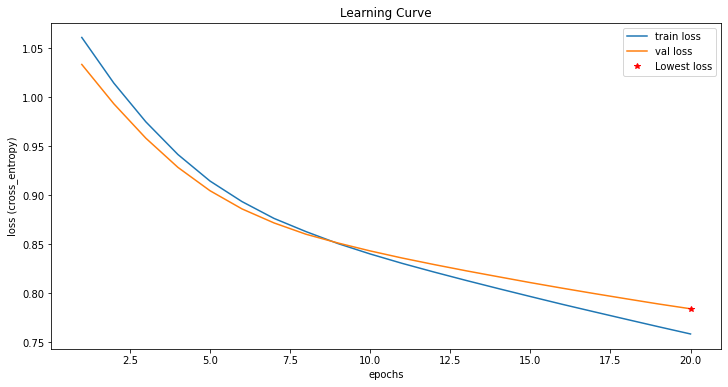

In [20]:
plt.figure("Loss Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label="train loss")
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label="val loss")
plt.plot(n+1,history.history["val_loss"][n],"r*", label="Lowest loss")
plt.legend()
plt.title("Learning Curve")
plt.ylabel("loss (cross_entropy)")
plt.xlabel("epochs")
plt.show();

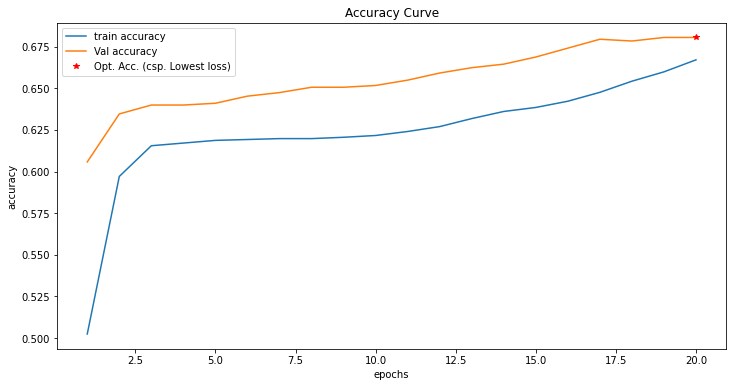

In [21]:
plt.figure("Accuracy Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label="train accuracy")
plt.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label="Val accuracy")
plt.plot(n+1,history.history["val_accuracy"][n],"r*", label="Opt. Acc. (csp. Lowest loss)")
plt.legend()
plt.title("Accuracy Curve")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.show()

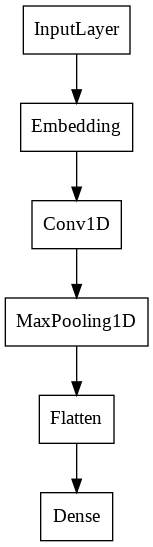

In [22]:
from keras.utils import plot_model
plot_model(model, to_file='RNN_LSTM_model.png', show_shapes=False, show_layer_names=False)